In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

#used for DBclustering and scaling
from sklearn.cluster import DBSCAN
#using MinMax b'c Standard can have LESSTHAN 0, and Epsolon is 0-1 only
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")

In [4]:
df.head(2)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776


In [5]:
# cluster on subset of features
grocery_milk_fresh = df[["Grocery", "Milk","Fresh"]]

In [6]:
grocery_milk_fresh.head(2)

,Grocery,Milk,Fresh
customer_id,,,
0,7561,9656,12669
1,9568,9810,7057


In [7]:
grocery_milk_fresh.columns

Index(['Grocery', 'Milk', 'Fresh'], dtype='object')

In [8]:
scaler = MinMaxScaler().fit(grocery_milk_fresh)
grocery_milk_fresh = scaler.transform(grocery_milk_fresh)

In [9]:
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(grocery_milk_fresh)

In [12]:
gmf_columns = ['Grocery', 'Milk', 'Fresh']


In [13]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)

scaled_columns = ["Scaled_" + column for column in gmf_columns]

In [14]:
columns

['Channel',
 'Region',
 'Fresh',
 'Milk',
 'Grocery',
 'Frozen',
 'Detergents_Paper',
 'Delicassen']

In [15]:
scaled_columns


['Scaled_Grocery', 'Scaled_Milk', 'Scaled_Fresh']

In [16]:
# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(grocery_milk_fresh, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [17]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
df['labels'] = labels
df.labels.value_counts()

 0    409
-1     31
Name: labels, dtype: int64

In [19]:
df[df.labels==-1].head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,labels
23,2,3,26373,36423,22019,5154,4337,16523,0.237300,0.495187,0.235136,-1
39,1,3,56159,555,902,10002,212,2916,0.009690,0.006808,0.500731,-1
45,2,3,5181,22044,21531,1740,7353,4985,0.232040,0.299402,0.046171,-1
47,2,3,44466,54259,55571,7782,24171,6465,0.598942,0.738042,0.396467,-1
49,2,3,4967,21412,28921,1798,13583,1163,0.311694,0.290797,0.044263,-1


In [20]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(df.describe())
print("-------------")
print("Inliers")
print(df[df.labels==0].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())

Population
          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen  Scaled_Grocery  \
count    440.000000        440.000000    440.000000      440.000000   
mean    3071.931818       2881.493182   1524.870455        0.085671   
std     4854.673333       4767.854448   2820.105937        0.102430   
min       25.000000 

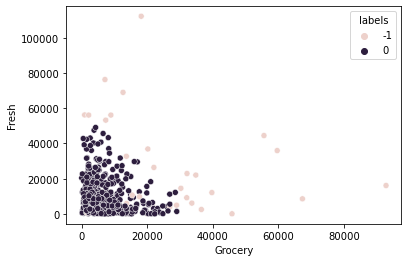

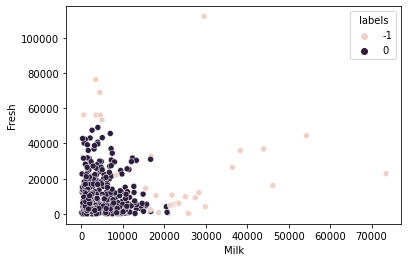

In [21]:
sns.scatterplot(df.Grocery, df.Fresh, hue=df.labels)
plt.show()

sns.scatterplot(df.Milk, df.Fresh, hue=df.labels)
plt.show()

Text(0.5, 0, 'Grocery')

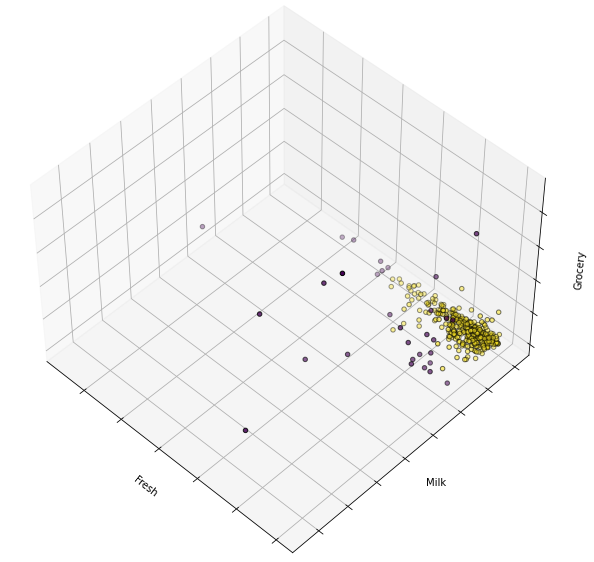

In [26]:
from mpl_toolkits.mplot3d import Axes3D

    
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Milk, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

In [27]:
%matplotlib qt

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Milk, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

Text(0.5, 0, 'Grocery')